In [1]:
import os
os.chdir(r'6 - Byte Pair encoding')
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.tensorboard import SummaryWriter
from itertools import chain, cycle, groupby
from functools import reduce
from typing import Collection, List
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)
from midi_encoding import *
from data_loading import *
from einops import rearrange, repeat, pack, unpack, einsum
import faiss
import time
import math
import pickle

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


# Byte Pair Encoding (BPE)

## What is the aim here?

- Increase information density in the context by introducing dedicated tokens for common pairs of tokens (and pairs of pairs, and pairs of those, etc etc)

This will be achieved by adapting the `Vocab` class to be *trainable*.

Training the `Vocab` class means feeding it a bunch of example data (which may or may not be the training set - rare items may be deliberately represented).

It uses this example data to *extend* the base vocabulary with pairs of tokens, and then pairs of those pairs etc etc. until the desired vocab size is reached.

This trained extended vocab can then be used to encode training data in a much more efficient, compressed form.

In our particular music-based case, you might imagine common chords being represented as a single token rather than a whole string of notes and durations.

> A C Major with notes that lasted slightly different lengths of time wouldn't be grouped unfortunately...

In [2]:
# Create a nested tensor
# Zeros represent the time idx
nested_tensor = torch.nested.nested_tensor([torch.tensor([[[1,0], [2,0]], [[3,0], [4,0]]]), torch.tensor([[[5,0], [6,0]]]), torch.tensor([[[7,0], [8,0]], [[9,0], [10,0]], [[11,0], [12,0]]])])
nested_tensor

/opt/conda/lib/python3.10/site-packages/torch/nested/__init__.py:166: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


nested_tensor([
  tensor([[[1, 0],
           [2, 0]],
  
          [[3, 0],
           [4, 0]]]),
  tensor([[[5, 0],
           [6, 0]]]),
  tensor([[[ 7,  0],
           [ 8,  0]],
  
          [[ 9,  0],
           [10,  0]],
  
          [[11,  0],
           [12,  0]]])
])

In [3]:
flattened_tensor = torch.cat([t.flatten(0,1) for t in nested_tensor.unbind()])
flattened_tensor

tensor([[ 1,  0],
        [ 2,  0],
        [ 3,  0],
        [ 4,  0],
        [ 5,  0],
        [ 6,  0],
        [ 7,  0],
        [ 8,  0],
        [ 9,  0],
        [10,  0],
        [11,  0],
        [12,  0]])

In [4]:
flattened_tensor[:, 0]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [123]:
class MusicVocab():
    def __init__(self):
        self.itos = {k:v for k,v in enumerate(ALL_TOKENS)}
        self.stoi = {v:k for k,v in enumerate(ALL_TOKENS)}
        self.idx_to_elem = {k:[k] for k,v in enumerate(ALL_TOKENS)} # 1 is [1], 2 is [2] etc. until we merge.
        self.merges = None
    
    def to_indices(self, tokens):
        return [self.stoi[w] for w in tokens]

    def to_tokens(self, idxs, sep=' '):
        items = [self.itos[idx] for idx in idxs]
        return sep.join(items) if sep is not None else items
    
    def to_element(self, idxs):
        return [self.idx_to_elem[idx] for idx in idxs]

    def get_stats(self, idxs):
        stats = {}
        for pair in zip(idxs[:-1], idxs[1:]):
            stats[pair] = stats.get(pair, 0) + 1
        return stats

    def merge(self, idxs, pos, pair, idx):
        new_idxs = []
        new_pos = None if pos is None else []
        i = 0
        while i < len(idxs):
            # Need to make sure we don't merge across time steps, otherwise we can't assign a tidx to the merged token
            current_item = idxs[i]

            if pos is not None:
                current_pos = pos[i]
                new_pos.append(current_pos)

            is_timestep_spanning = i > 0 and idxs[i-1] == self.sep_idx
            next_item = idxs[i+1] if i < len(idxs) - 1 else None

            if not is_timestep_spanning and next_item is not None and current_item == pair[0] and next_item == pair[1]:
                new_idxs.append(idx)
                i += 2
            else:
                new_idxs.append(current_item)
                i += 1

        return new_idxs, new_pos

    # Pass in data already encoded using untrained vocab
    def train(self, dataset, max_vocab_size):

        if self.merges is not None:
            raise Exception("Already trained")
        
        self.merges = {}

        # Might have to skip the clone, depending on memory usage
        idxs = torch.cat([t.flatten(0,1) for t in dataset.data.unbind()]) # Flatten the nested tensor
        idxs = idxs[:, 0].detach().cpu().tolist() # Discard time idx and convert to list
        initial_size = self.size
        num_merges = max_vocab_size - initial_size

        for i in range(num_merges):
            stats = self.get_stats(idxs)
            pair = max(stats, key=stats.get)
            idx = initial_size + i
            print(f"Merging {pair} to a new token {idx}")
            idxs, _ = self.merge(idxs, None, pair, idx)
            self.merges[pair] = idx
        
        for (p0, p1), idx in self.merges.items():
            value = f"{self.itos[p0]} {self.itos[p1]}"
            self.itos[idx] = value
            self.stoi[value] = idx
            self.idx_to_elem[idx] = self.idx_to_elem[p0] + self.idx_to_elem[p1]
    
    def state_dict(self):
        return {
            'idx_to_elem': self.idx_to_elem,
            'merges': self.merges
        }
    
    def load_state_dict(self, state_dict):
        self.merges = state_dict['merges']
        self.idx_to_elem = state_dict['idx_to_elem']
        self.itos = {k:self.to_tokens(v) for k,v in enumerate(self.idx_to_elem.values())}
        self.stoi = {v:k for k,v in enumerate(self.itos.values())}
    
    def encode(self, note_position_score):
        nps = note_position_score.copy()
        note_dur_score = nps[:, :2] # Note and duration, drop tidx
        
        # Offset the note and duration values by the min index to get their index
        note_min_idx, _ = self.note_range
        dur_min_idx, _ = self.duration_range
        note_idx_score = note_dur_score + np.array([note_min_idx, dur_min_idx])

        note_idx_score = note_idx_score.reshape(-1) # Flatten note and duration into a single dimension
        pos_score = np.repeat(nps[:, 2], 2) # Double up positions for flattened note and duration
        
        while True:
            stats = self.get_stats(note_idx_score)

            # Iterate keys and get the pair with the min number of merges, so we do earlier merges first
            pair = min(stats, key=lambda p: self.merges.get(p, float('inf')))
            
            if pair not in self.merges:
                print("No more merges to do")
                break
            else:
                idx = self.merges[pair]
                print(f"Replacing {pair} with token {idx}")
                note_idx_score, pos_score = self.merge(note_idx_score, pos_score, pair, idx)

        return np.array(note_idx_score), np.array(pos_score)
    
    def decode(self, note_idx_score):
        # Convert idxs to positions and pair up note / durations
        merge_chunks = [self.idx_to_elem[idx] for idx in note_idx_score]
        position_score = np.array(list(chain(*merge_chunks))).reshape(-1, 2)

        # Offset the note and duration idxs by their respective min index to get their actual value
        if position_score.shape[0] != 0: 
            note_min_idx, _ = self.note_range
            dur_min_idx, _ = self.duration_range
            position_score -= np.array([note_min_idx, dur_min_idx])

        return position_score

    @property
    def sos_idx(self): return self.stoi[SOS]
    @property
    def eos_idx(self): return self.stoi[EOS]
    @property
    def sep_idx(self): return self.stoi[SEP]
    @property
    def pad_idx(self): return self.stoi[PAD]
    @property
    def note_position_enc_range(self): return (self.stoi[SEP], self.size)
    @property
    def note_range(self): return self.stoi[NOTE_START], self.stoi[NOTE_END]+1
    @property
    def duration_range(self): return self.stoi[DURATION_START], self.stoi[DURATION_END]+1
    @property
    def size(self): return len(self.itos)

Question
- Should we consider SEPARATOR_IDX as a hard terminator of bpe (like a word space) and pre-chunk into simultaneous 'actions'? Instead of 'optional space followed by a sequence of chars' it would be 'optional separator followed by an action (sequence of notes and durations)'.

Answer: 
- No need because an 'action' is *always* followed by a separator, it's not like we have a range of punctuation to differentiate (i.e. dog. vs dog, vs dog!).
- However we did need to prevent merging across time index boundaties to ensure each token had a distinct timestep, which meant skipping a merge during encoding if the previous pair was SEP, DUR

In [6]:
dataset_vocab = MusicVocab()

In [7]:
sample_length = 256
max_file_length = 32
vg_large_path = Path('../data/midi/vg_large')
vg_large_file_names = [f for f in os.listdir(vg_large_path) if os.path.isfile(os.path.join(vg_large_path, f))]
midi_path = Path('../data/midi/vg_large')
score_path = Path(f'../data/numpy/vg_large/all')

dataset = MidiDataset(vg_large_file_names, midi_path, score_path, sample_length, max_file_length)

In [8]:
dataset.load_samples(dataset_vocab, device) # Could load directly to CPU here as it is only used for training the vocab but wanted to replicate existing code

In [124]:
vocab = MusicVocab()
init_vocab_size = vocab.size
init_vocab_size

389

In [125]:
vocab.train(dataset, max_vocab_size=395)

Merging (3, 136) to a new token 389
Merging (136, 389) to a new token 390
Merging (2, 2) to a new token 391
Merging (3, 134) to a new token 392
Merging (134, 392) to a new token 393
Merging (134, 389) to a new token 394


In [126]:
trained_vocab_size = vocab.size

In [127]:
for idx in range(init_vocab_size, init_vocab_size + 6):
    print(f"{idx}: {vocab.itos[idx]}")

389: <|sep|> d4
390: d4 <|sep|> d4
391: <|pad|> <|pad|>
392: <|sep|> d2
393: d2 <|sep|> d2
394: d2 <|sep|> d4


In [128]:
for idx in range(init_vocab_size, init_vocab_size + 6):
    print(f"{idx}: {vocab.idx_to_elem[idx]}")

389: [3, 136]
390: [136, 3, 136]
391: [2, 2]
392: [3, 134]
393: [134, 3, 134]
394: [134, 3, 136]


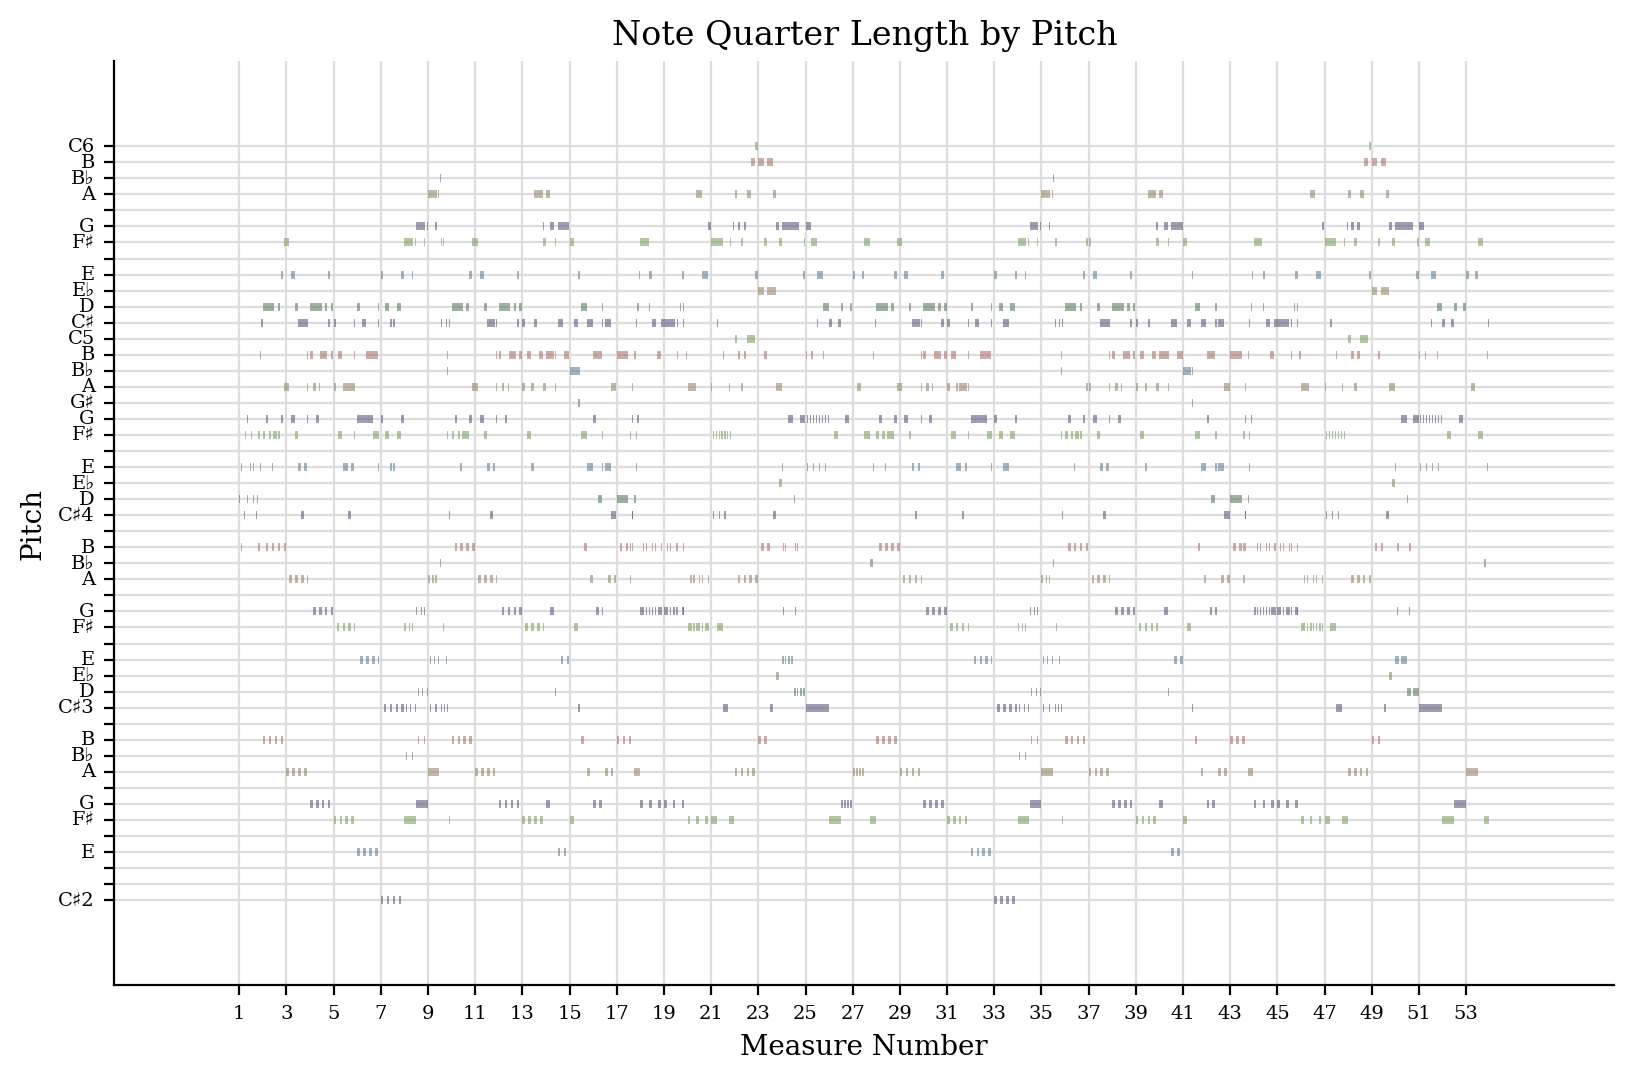

In [129]:
final_fantasy_midi_path = Path('../data/midi/Mana_GB_Final Fantasy Adventure_Battle 2.mid')
final_fantasy_midi = m21.midi.MidiFile()
final_fantasy_midi.open(final_fantasy_midi_path)
final_fantasy_midi.read()
final_fantasy_midi.close()

final_fantasy_m21stream = m21.midi.translate.midiFileToStream(final_fantasy_midi)
final_fantasy_m21stream.plot()

In [130]:
final_fantasy_idx_score = midifile_to_idx_score(final_fantasy_midi_path, vocab)

vocab.to_tokens(final_fantasy_idx_score[:, 0])

Replacing (3, 136) with token 389
Replacing (136, 389) with token 390
Replacing (3, 134) with token 392
Replacing (134, 392) with token 393
Replacing (134, 389) with token 394
No more merges to do


'<|sos|> n62 d2 <|sep|> d2 n64 d2 n59 d2 <|sep|> d4 n61 d2 <|sep|> d2 n66 d2 <|sep|> d2 n67 d2 n62 d2 <|sep|> d4 n64 d2 <|sep|> d2 n66 d2 <|sep|> d2 n64 d2 n62 d2 <|sep|> d4 n61 d2 <|sep|> d2 n62 d2 <|sep|> d2 n66 d2 n59 d2 <|sep|> d2 n71 d2 n64 d2 <|sep|> d2 n73 d2 <|sep|> d2 n74 d16 n66 d4 n47 d4 <|sep|> d4 n67 d4 n59 d4 <|sep|> d4 n66 d4 n47 d4 <|sep|> d4 n64 d2 n59 d4 <|sep|> d2 n66 d6 <|sep|> d2 n47 d4 <|sep|> d4 n74 d4 n66 d4 n59 d4 <|sep|> d4 n76 d4 n67 d4 n47 d4 <|sep|> d4 n78 d4 n69 d4 n59 d4 <|sep|> d4 n78 d4 n69 d4 n45 d4 <|sep|> d4 n57 d4 <|sep|> d2 n76 d6 n67 d6 <|sep|> d2 n45 d4 <|sep|> d4 n74 d4 n66 d4 n57 d4 <|sep|> d4 n73 d12 n64 d4 n45 d4 <|sep|> d4 n61 d4 n57 d4 <|sep|> d4 n64 d4 n45 d4 <|sep|> d4 n73 d2 n71 d2 n69 d2 n67 d2 n57 d2 <|sep|> d4 n74 d16 n71 d4 n43 d4 <|sep|> d4 n69 d4 n55 d4 <|sep|> d4 n67 d4 n43 d4 <|sep|> d4 n69 d2 n55 d4 <|sep|> d2 n71 d10 <|sep|> d2 n43 d4 <|sep|> d4 n74 d4 n55 d4 <|sep|> d4 n76 d4 n73 d4 n43 d4 <|sep|> d4 n74 d4 n71 d4 n55 d4 <|sep

In [131]:
final_fantasy_idx_score.shape # 3162 before adding 6 tokens to the vocab

(2262, 2)

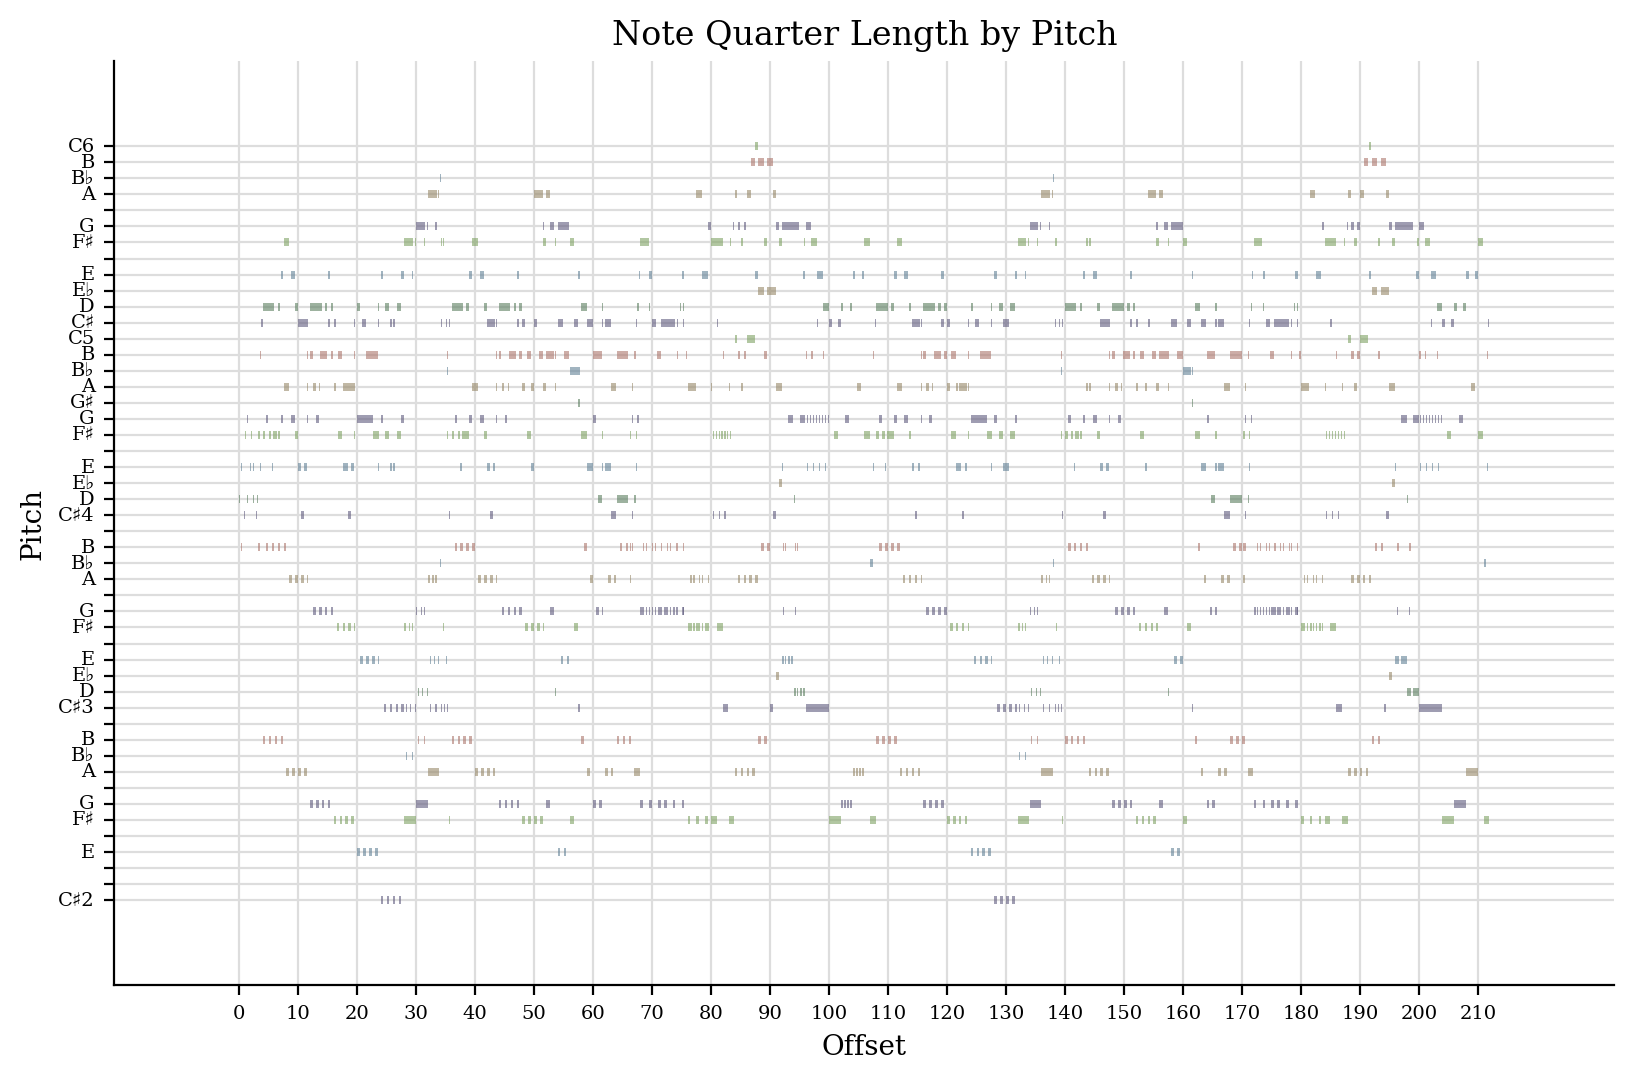

In [132]:
reconstructed_final_fantasy_stream = idx_to_stream_enc(final_fantasy_idx_score[:, 0], vocab)
reconstructed_final_fantasy_stream.plot()

In [133]:
final_fantasy_m21stream.show('midi')

In [134]:
reconstructed_final_fantasy_stream.show('midi')

It works!

## Save / Restore

It is important that we use the same vocab to decode data that we used to encode it, otherwise tokens might not exist or have other meanings.

This also goes for decoding performances generated by the model. We must use the same vocab which encoded the training data (and all training data must have been encoded with the same vocab). This stands to reason, otherwise tokens will have no consistent meaning.

For this reason we should save it alongside our model during training so that we can load it during inference.

In [135]:
trained_state = vocab.state_dict()

untrained_vocab = MusicVocab()
untrained_vocab.size

389

In [136]:
untrained_vocab.load_state_dict(trained_state)
untrained_vocab.size

395

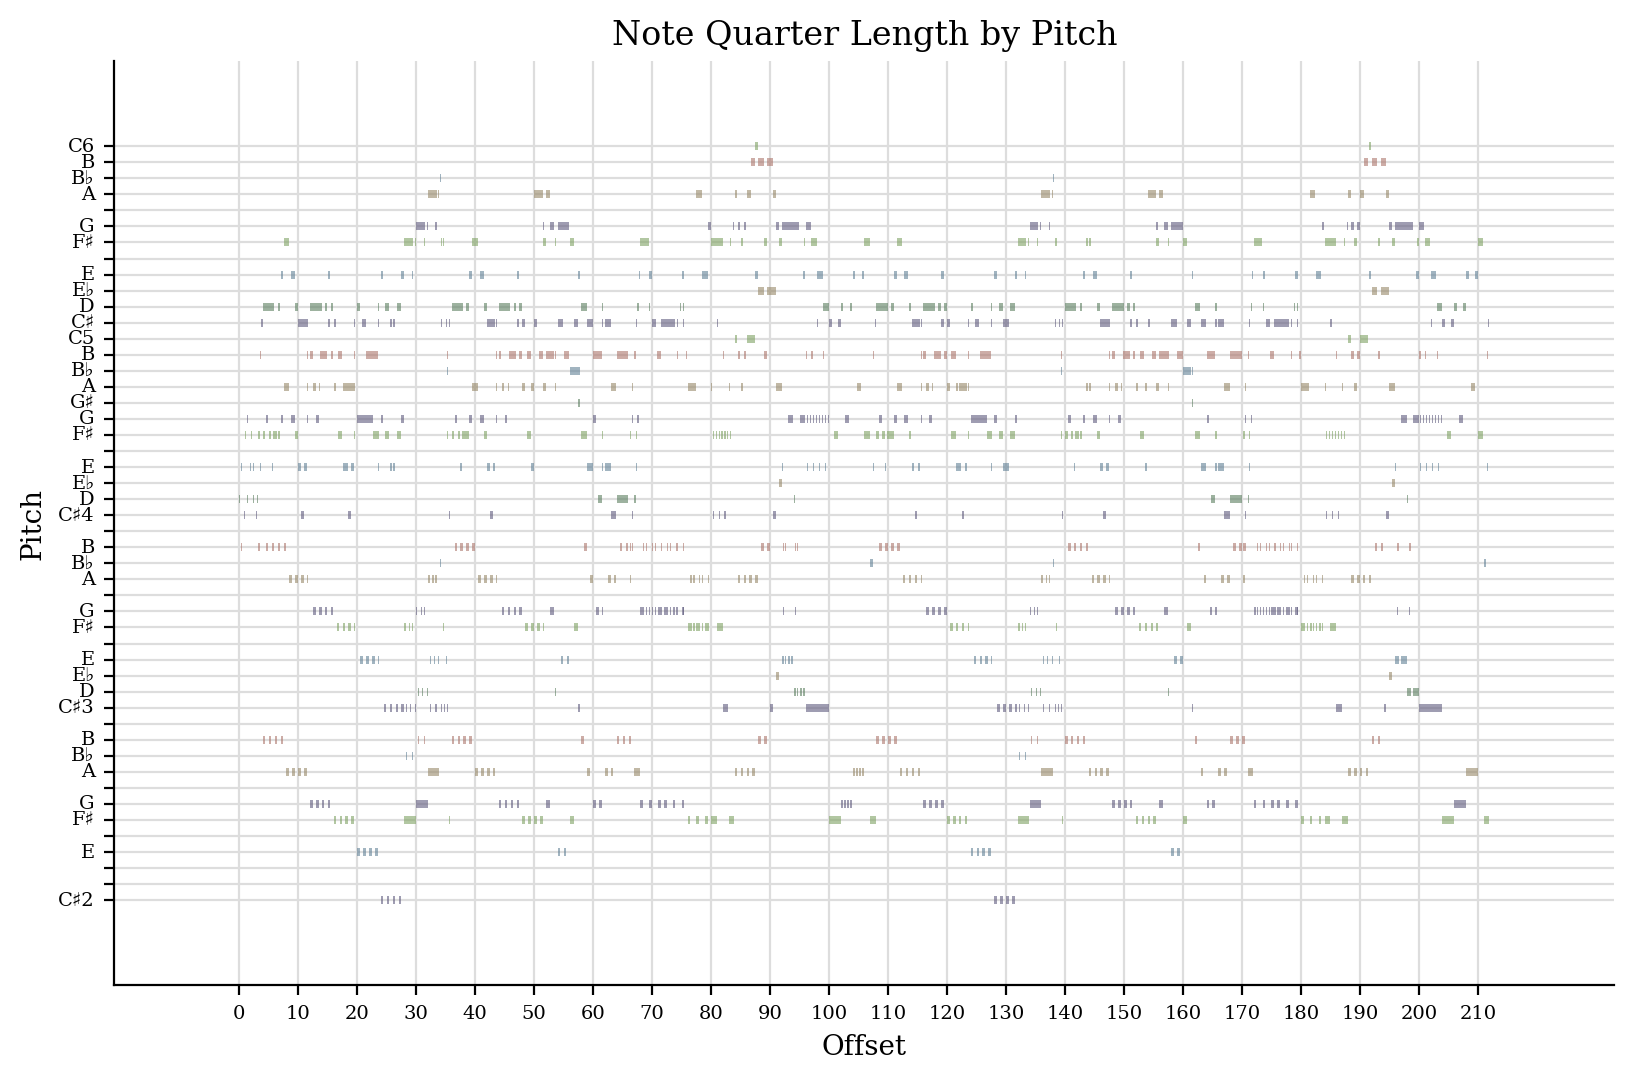

In [140]:
untrained_final_fantasy_stream = idx_to_stream_enc(final_fantasy_idx_score[:, 0], untrained_vocab)
untrained_final_fantasy_stream.plot()

In [143]:
untrained_final_fantasy_stream.show('midi')

In [146]:
for v in untrained_vocab.itos.items():
    print(v)

(0, '<|sos|>')
(1, '<|eos|>')
(2, '<|pad|>')
(3, '<|sep|>')
(4, 'n0')
(5, 'n1')
(6, 'n2')
(7, 'n3')
(8, 'n4')
(9, 'n5')
(10, 'n6')
(11, 'n7')
(12, 'n8')
(13, 'n9')
(14, 'n10')
(15, 'n11')
(16, 'n12')
(17, 'n13')
(18, 'n14')
(19, 'n15')
(20, 'n16')
(21, 'n17')
(22, 'n18')
(23, 'n19')
(24, 'n20')
(25, 'n21')
(26, 'n22')
(27, 'n23')
(28, 'n24')
(29, 'n25')
(30, 'n26')
(31, 'n27')
(32, 'n28')
(33, 'n29')
(34, 'n30')
(35, 'n31')
(36, 'n32')
(37, 'n33')
(38, 'n34')
(39, 'n35')
(40, 'n36')
(41, 'n37')
(42, 'n38')
(43, 'n39')
(44, 'n40')
(45, 'n41')
(46, 'n42')
(47, 'n43')
(48, 'n44')
(49, 'n45')
(50, 'n46')
(51, 'n47')
(52, 'n48')
(53, 'n49')
(54, 'n50')
(55, 'n51')
(56, 'n52')
(57, 'n53')
(58, 'n54')
(59, 'n55')
(60, 'n56')
(61, 'n57')
(62, 'n58')
(63, 'n59')
(64, 'n60')
(65, 'n61')
(66, 'n62')
(67, 'n63')
(68, 'n64')
(69, 'n65')
(70, 'n66')
(71, 'n67')
(72, 'n68')
(73, 'n69')
(74, 'n70')
(75, 'n71')
(76, 'n72')
(77, 'n73')
(78, 'n74')
(79, 'n75')
(80, 'n76')
(81, 'n77')
(82, 'n78')
(83, 'n7

In [142]:
for v in untrained_vocab.stoi.items():
    print(v)

('<|sos|>', 0)
('<|eos|>', 1)
('<|pad|>', 2)
('<|sep|>', 3)
('n0', 4)
('n1', 5)
('n2', 6)
('n3', 7)
('n4', 8)
('n5', 9)
('n6', 10)
('n7', 11)
('n8', 12)
('n9', 13)
('n10', 14)
('n11', 15)
('n12', 16)
('n13', 17)
('n14', 18)
('n15', 19)
('n16', 20)
('n17', 21)
('n18', 22)
('n19', 23)
('n20', 24)
('n21', 25)
('n22', 26)
('n23', 27)
('n24', 28)
('n25', 29)
('n26', 30)
('n27', 31)
('n28', 32)
('n29', 33)
('n30', 34)
('n31', 35)
('n32', 36)
('n33', 37)
('n34', 38)
('n35', 39)
('n36', 40)
('n37', 41)
('n38', 42)
('n39', 43)
('n40', 44)
('n41', 45)
('n42', 46)
('n43', 47)
('n44', 48)
('n45', 49)
('n46', 50)
('n47', 51)
('n48', 52)
('n49', 53)
('n50', 54)
('n51', 55)
('n52', 56)
('n53', 57)
('n54', 58)
('n55', 59)
('n56', 60)
('n57', 61)
('n58', 62)
('n59', 63)
('n60', 64)
('n61', 65)
('n62', 66)
('n63', 67)
('n64', 68)
('n65', 69)
('n66', 70)
('n67', 71)
('n68', 72)
('n69', 73)
('n70', 74)
('n71', 75)
('n72', 76)
('n73', 77)
('n74', 78)
('n75', 79)
('n76', 80)
('n77', 81)
('n78', 82)
('n79', 